In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

## use wrds package to connect to WRDS
import wrds
wrds_user = os.getenv("WRDS_USER")
db = wrds.Connection(wrds_username=wrds_user)

Loading library list...
Done


## 1. Principal Component Analysis (PCA)

- **Basic Principles and Mathematical Formulation**
  - Core ideas: finding the optimal hyperplane such that:
    - **Minimum reconstruction error**: minimize the distance from sample points to the hyperplane
    - **Maximum separability**: maximize the variance of the projected samples

  - Algorithm steps:
    1. **Data standardization**:  
       $$
       x_{ij}^* = \frac{x_{ij} - \bar{x}_j}{\sqrt{\text{Var}(x_j)}}
       $$
    2. **Compute the correlation matrix**:  
       $$
       R = \frac{Z'Z}{n-1}, \quad Z = \text{standardized data matrix}
       $$
    3. **Eigen-decomposition**:  
       $$
       R = U\Lambda U', \quad \Lambda = \text{diag}(\lambda_1,...,\lambda_p)
       $$
    4. **Extract principal components**:  
       $$
       Y_i = Xu_i, \quad u_i = \text{eigenvector of the $i$-th largest eigenvalue}
       $$

- **Advantages and Limitations**

| Advantages       | Explanation                              | Limitations      | Explanation                                  |
|------------------|------------------------------------------|------------------|----------------------------------------------|
| Data compression | Increases sample density and usability   | Poor interpretability | Principal components lack economic meaning |
| Noise reduction  | Discarded components often correspond to noise | Linear assumption | Only captures linear relationships |
| Ease of use      | Requires no complex parameter tuning     | Distribution-sensitive | Less effective under non-Gaussian distributions |

- **Extensions**

  - **Instrumented PCA (IPCA)**
    - Proposed by: Kelly et al. (2021)
    - Model form:
      $$
      r_{i,t+1} = a_{i,t} + \beta_{i,t}f_{t+1} + \epsilon_{i,t+1}
      $$
      $$
      a_{i,t} = x'_{i,t}\Gamma_a + v_{a,t}, \quad \beta_{i,t} = x'_{i,t}\Gamma_\beta + v_{\beta,t}
      $$
    - Features:
      - Introduces time-varying β to capture dynamic risk premia
      - Distinguishes between systematic risk ($\Gamma_\beta$) and idiosyncratic risk ($\Gamma_\alpha$)

  - **Scaled PCA (sPCA)**
    - Huang, D., Jiang, F., Li, K., Tong, G., & Zhou, G. (2022). *Scaled PCA: A new approach to dimension reduction.* Management Science.
      - Construct effective predictor set:  
        $$
        y_{t+h} = v_i + \gamma_i X_{i,t} + u_{i,t+h}
        $$
      - Apply PCA to scaled predictors
    - Higher-weight is given to information-rich variables
    - Lower-weight is assigned to noisy variables


In [3]:
from sklearn.decomposition import PCA

In [4]:
### Obtain S&P500 data
sp500_df = db.raw_sql("""select * 
                        from crsp_a_indexes.msp500
                        where 
                        caldt >= '08/01/2004' and             
                        caldt <= '12/31/2013'
                    """, date_cols=['caldt'])    #  02/01/2005 & 12/31/2013 11/01/2004 & 12/31/2013  08/01/2004 & 12/31/2013

sp500_df.set_index(["caldt"], drop=True, inplace=True)
sp500_df

,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
caldt,,,,,,,,,,
2004-08-31,0.003807,0.002019,-0.002948,-0.004771,10202644100.0,500,10177769000.0,500,1104.24,0.002287
2004-09-30,0.010817,0.009347,0.02757,0.026265,10285563700.0,500,10200534100.0,500,1114.58,0.009364
2004-10-29,0.014973,0.013699,0.024507,0.023589,10400365400.0,500,10253103200.0,500,1130.2,0.014014
2004-11-30,0.040559,0.035572,0.058717,0.05686,10775860400.0,500,10392258900.0,500,1173.82,0.038595
2004-12-31,0.033734,0.032086,0.037578,0.035933,11174847000.0,500,10810662000.0,500,1211.92,0.032458
...,...,...,...,...,...,...,...,...,...,...
2013-08-30,-0.029207,-0.031638,-0.027829,-0.029855,14967939700.0,500,15481333300.0,500,1632.97,-0.031298
2013-09-30,0.03166,0.030064,0.040402,0.038552,15425476800.0,500,14998800000.0,500,1681.55,0.02975
2013-10-31,0.046268,0.044953,0.042828,0.041839,16084261800.0,500,15417335700.0,500,1756.54,0.044596


In [5]:
## Macroeconomic predictors (from Amit Goyal homepage)
# Variables:
#   D12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index.
#   E12: Earnings are 12-month moving sums of earnings on the S&P500 index.
#   B/M: Book-to-market ratio
#   TBL: T-Bill rates (U.S. Yields On Short-Term United States Securities,)
#   AAA(BAA): Corporate Bond Yields on AAA(BAA)-related bonds
#   Lty: long-term government bond yield
#   Ntis: Net issuing activity.
#   infl: inflation
#   SVAR: Stock Variance is computed as sum of squared daily returns on the S&P 500.
predictors = pd.read_csv(os.path.join('data', 'l5', "PredictorData2024.csv"), index_col=0).iloc[:-2,:]
predictors.loc[:,'Dates'] = predictors.index.astype(int).astype(str).values
predictors.set_index(pd.to_datetime(predictors.loc[:,'Dates'], format="%Y%m"), inplace = True)
X = predictors.loc["2004-07-01":"2013-11-01", ['D12','E12','b/m','tbl','AAA','BAA','lty','ntis','infl','ltr','svar']].copy(deep=True)
y = sp500_df.loc[:,'sprtrn'].values - predictors.loc["2004-08-01":"2013-12-01",'Rfree'].values
X 

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,svar
Dates,,,,,,,,,,,
2004-07-01,18.7890,56.6900,0.287788,0.0133,0.0582,0.0662,0.0523,0.014721,-0.001581,0.0155,0.000777
2004-08-01,18.9760,57.2300,0.286821,0.0148,0.0565,0.0646,0.0493,0.014279,0.000528,0.0395,0.001443
2004-09-01,19.1630,57.7700,0.289485,0.0165,0.0546,0.0627,0.0488,0.009132,0.002111,0.0096,0.000706
2004-10-01,19.2560,58.0300,0.291010,0.0176,0.0547,0.0621,0.0478,0.007429,0.005266,0.0154,0.001230
2004-11-01,19.3490,58.2900,0.279832,0.0207,0.0552,0.0620,0.0502,0.012177,0.000524,-0.0234,0.000857
...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01,33.6455,92.0900,0.325563,0.0004,0.0434,0.0532,0.0344,0.008361,0.000394,-0.0173,0.000502
2013-08-01,34.0247,93.2300,0.340713,0.0004,0.0454,0.0542,0.0351,0.010332,0.001203,-0.0079,0.000950
2013-09-01,34.4039,94.3700,0.333521,0.0002,0.0464,0.0547,0.0349,0.010119,0.001163,0.0061,0.000622


In [6]:
def Norm(in_df, no_Norm=[]):
    op_df = in_df.copy()
    for col in op_df.columns:
        if col in no_Norm:
            continue
        else:
            col_max = max(op_df[col])
            col_min = min(op_df[col])
            if col_max == col_min:
                continue
            op_df[col] = (op_df[col] - col_min) / (col_max - col_min)
    return op_df

In [7]:
# PCA analysis
X_normed = Norm(X)
n = 6
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_normed)

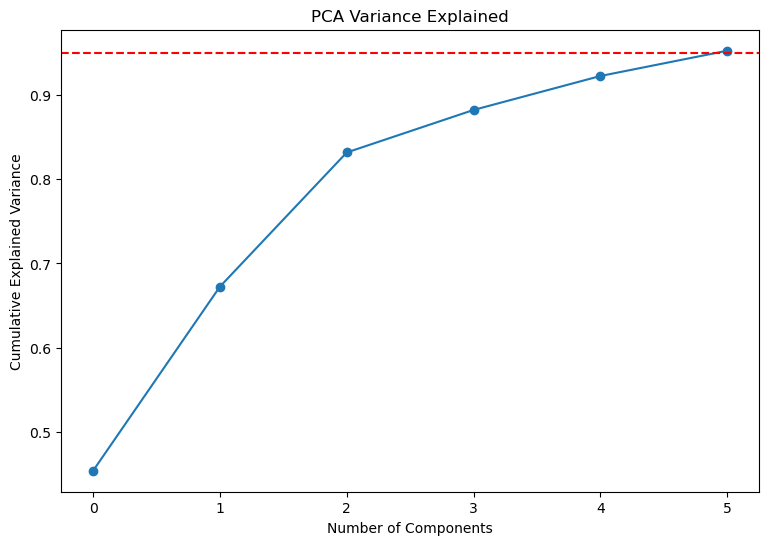

In [8]:
# PCA Visualization
plt.figure(figsize=(9, 6))

# Explained Variance Ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('PCA Variance Explained')
plt.show()

Text(0.5, 1.0, 'PCA Loading Matrix')

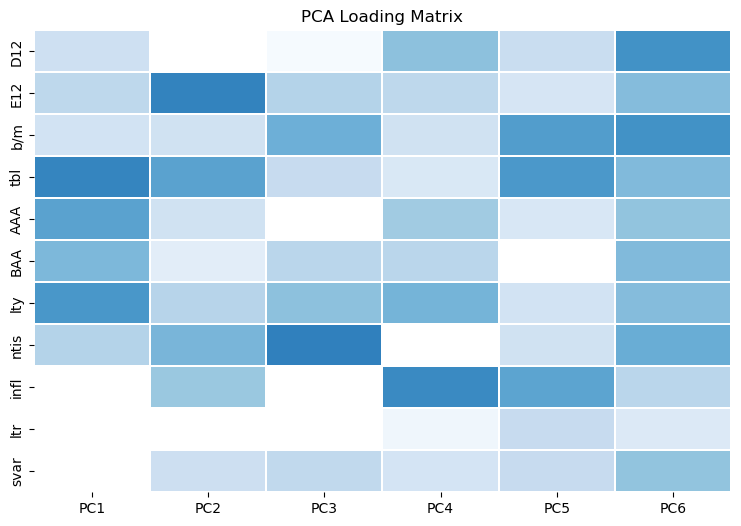

In [9]:
# Feature Vector Heatmap
pca_comp_df = pd.DataFrame(pca.components_.T, index=X.columns, columns=["PC%i" % i for i in range(1,n+1)])
f, ax = plt.subplots(figsize = (9,6))
new_blues=sns.color_palette("Blues", 100)[0:70]         # 设置颜色参数，基调为蓝色
sns.heatmap(pca_comp_df, mask=(abs(pca_comp_df)<0.05), cmap=new_blues, yticklabels=True, linewidths = 0.005, linecolor= 'white', ax = ax, cbar = False)
ax.set_title('PCA Loading Matrix')

## 2. Partial Least Squares Regression (PLS)

- **Basic Principles and Mathematical Formulation**
  - Core ideas:
    - Extract components in the directions of maximum covariance between X and Y to address multicollinearity and high-dimensional problems.
    - Iterative algorithm based on target information  
      1. **Initialization**:  
         $ z_{t,0} = y_{t+h} $
      2. **For the k-th component (k = 1,...,r), compute as follows**:  
         - **Time-series regression to estimate $\hat{A_i}$**:  
           $ X_{it} = a_i + z'_{t,k-1}A_i + v_{i,t} $
         - **Cross-sectional regression at time t to estimate $\hat{B_t}$**:  
           $ X_{it} = \hat{A}_iB_t + v_{i,t}^* $
         - **Forecast regression**:  
           $ y_{t+h} = \alpha + \hat{B}_t\beta + \epsilon_{t+h} $
      3. **Update residuals and iterate Step 2**:  
         $ z_k = (z_{k-1}, \hat{\epsilon}^{(k)}) $, until the r-th component is obtained.

- **Comparison with Traditional Methods**

| Feature             | OLS                | PLS                          |
|---------------------|--------------------|------------------------------|
| **Matrix requirement** | $X'X$ invertible   | No requirement               |
| **Collinearity handling** | Fails              | Effective                    |
| **Component interpretation** | None             | Clear optimization target    |
| **Small-sample performance** | Overfitting       | Stable                       |

- **Advantages and Limitations**
  - Advantages:
    1. **Robust to multicollinearity**: avoids directly inverting the $X'X$ matrix.
    2. **Suitable for small samples**: effective when $n < p$.
    3. **Dual dimensionality reduction**: considers both X and Y structures simultaneously.
  - Limitations:
    1. **Sensitive to variable count**: requires at least 3 variables.
    2. **Interpretation complexity**: economic meaning of components is not intuitive.
    3. **Cumulative contribution risk**: may not reach threshold requirements.

- **Extended Applications**

  - **Dynamic PLS (DPLS)**
    - **Improvements**:
      - Incorporates time-series structure.
      - Objective function:  
        $$
        \max \sum_{t=1}^T \text{Cov}^2(X_tw, Y_{t+h})
        $$


In [10]:
from sklearn.cross_decomposition import PLSRegression

In [11]:
# PLS analysis
n = 4
pls = PLSRegression(n_components=n)
pls.fit(X_normed, y)
X_pls = pls.transform(X_normed)
pls.coef_

array([[ 0.01378983, -0.01279426,  0.07122543,  0.01949301,  0.00196856,
         0.00366652, -0.01570974,  0.00159726,  0.02427304,  0.05982686,
        -0.12885449]])

Text(0.5, 1.0, 'PLS Weight Matrix')

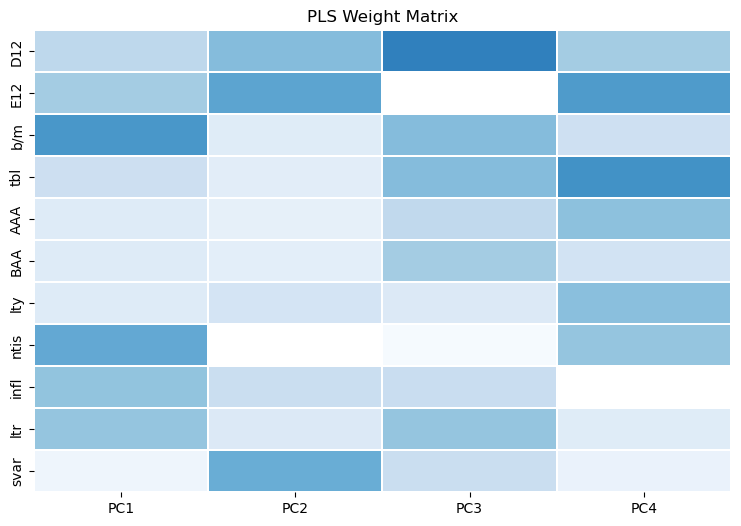

In [12]:
# PLS Weight Matrix Heatmap
pls_comp_df = pd.DataFrame(pls.x_weights_, index=X_normed.columns, columns=["PC%i" % i for i in range(1,n+1)])
f, ax = plt.subplots(figsize = (9,6))
new_blues=sns.color_palette("Blues", 100)[0:70]        
sns.heatmap(pls_comp_df, mask=(abs(pls_comp_df)<0.05), cmap=new_blues, yticklabels=True, linewidths = 0.005, linecolor= 'white', ax = ax, cbar = False)
ax.set_title('PLS Weight Matrix')

### A comprehensive forecasting application

In [13]:
def calculate_R_OOS_2(y_oos_bar, y_oos, y_hat_oos):
    """
    Calculate the out-of-sample predictive R-squared statistic (R2_OOS),
    used to evaluate a forecasting model relative to the historical mean benchmark.
    
    Parameters
    -----------
    y_oos_bar : array-like
        Benchmark forecast values computed using the historical mean (naive forecast).
    y_oos : array-like
        Sequence of actual out-of-sample observed values.
    y_hat_oos : array-like
        Out-of-sample forecast values generated by the predictive model.

    Returns
    -------
    float
        R2_OOS in percentage form (range: 0-100), rounded to 2 decimal places.  
        A positive value indicates the model outperforms the historical mean benchmark.
    
    Algorithm
    ---------
    1. Compute the model's mean squared forecast error (MSFE_model).
    2. Compute the benchmark (historical mean) mean squared forecast error (MSFE_benchmark).
    3. R2_OOS = (1 - MSFE_model / MSFE_benchmark) * 100
    4. As a rule of thumb, R2_OOS > 2% is considered economically meaningful.
    """

    numerator = np.sum((y_oos - y_hat_oos) ** 2)
    denominator = np.sum((y_oos - y_oos_bar) ** 2)
    R_OOS_2 = round((1 - numerator / denominator) * 100, 2)
    return R_OOS_2


def calculate_DM_statistic(e1_t, e2_t, alpha=0.05):
    """
    Perform the Diebold–Mariano (DM) test to compare the predictive accuracy 
    of two forecasting models.
    
    Parameters
    -----------
    e1_t : array-like
        Forecast error series of Model 1 (actual value - predicted value).
    e2_t : array-like
        Forecast error series of Model 2.
    alpha : float, optional
        Significance level threshold (default = 0.05).
        
    Returns
    -------
    tuple
        (DM statistic, p-value)
        
    Test Description
    ----------------
    1. Null hypothesis: Predictive accuracy of Model 1 = Model 2.
    2. Alternative hypothesis: Predictive accuracy of Model 1 < Model 2.
    3. The test statistic is constructed from the standardized mean 
       of the squared error differences.
    4. Applicable for comparing non-nested models.
    """
    d_12t = (e1_t ** 2) - (e2_t ** 2)
    T = len(d_12t)
    d_bar_12 = np.mean(d_12t)
    std_d_bar_12 = np.std(d_12t, ddof=1) / np.sqrt(T)
    DM_statistic = d_bar_12 / std_d_bar_12
    p_value = 1 - stats.norm.cdf(DM_statistic)
    return DM_statistic, p_value


def calculate_CW_statistic(r_set):
    """
        Compute the Clark-West (CW) statistic, designed for comparing 
        the predictive accuracy of nested models.
        
        Parameters
        -----------
        r_set : DataFrame
            Must contain three columns:
            - r_real: actual observed values
            - r_bar: benchmark forecast from the historical mean
            - r_hat: model forecast values
            
        Returns
        -------
        float
            CW statistic (adjusted MSPE statistic)
            
        Method Features
        ---------------
        1. A modified Diebold-Mariano test specifically for nested models.
        2. Corrects the bias in nested model comparison by adjusting forecast errors.
        3. Employs HAC standard errors to handle autocorrelation.
        4. The statistic is asymptotically standard normal.
    """
    r_set['u0_hat2'] = (r_set['r_real'] - r_set['r_bar']) ** 2     # baseline model error
    r_set['ui_hat2'] = (r_set['r_real'] - r_set['r_hat']) ** 2     # predictive model error
    r_set['d'] = r_set['u0_hat2'] - (r_set['ui_hat2'] - (r_set['r_bar'] - r_set['r_hat']) ** 2)
    N = r_set.dropna().shape[0]
    L = int(np.ceil(4 * (N / 100) ** (2 / 9)))
    X = sm.add_constant(r_set['d'].to_numpy())
    y = r_set['r_real'].to_numpy()
    reg = sm.OLS(y, X)
    result = reg.fit(cov_type='HAC', use_t=True, cov_kwds={'maxlags': L})
    CW_statistic = result.tvalues[0].astype(float).round(4)
    p_value = 1 - stats.norm.cdf(CW_statistic)
    
    return CW_statistic, p_value


In [14]:
def PCA_method(in_X_train, in_y_train, in_X_test, in_y_test, in_X_oos, in_test_data, in_oos_data):
    """
        Perform dimensionality reduction using Principal Component Analysis (PCA),
        and fit a linear regression model on the reduced data.
        
        Parameters
        ----------
        in_X_train : array-like
            Training feature data (used to estimate parameters).
        in_y_train : array-like
            Training target variable.
        in_X_test : array-like
            Test feature data (used to select the optimal hyperparameter).
        in_y_test : array-like
            Test target variable.
        in_X_oos : array-like
            Out-of-sample feature data (used to evaluate model performance).
        in_test_data : DataFrame
            Test set including date and target variable.
        in_oos_data : DataFrame
            Out-of-sample data including date and target variable.
        
        Returns
        -------
        ret_oos : dict
            Prediction results for all numbers of principal components.
        data_pca : DataFrame
            Prediction results using the optimal number of principal components.
        importance_dict : dict
            Principal component importance (explained variance ratio).
        exp_ratio_dict : dict
            Cumulative explained variance ratio.
    """
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression

    # initialize variables to store results
    mse = []  # store mean squared error for different numbers of principal components
    ret_test = []
    ret_oos = []  # store prediction results for all numbers of principal components
    importance_dict = {}  # store principal component importance
    exp_ratio_dict = {}  # store cumulative explained variance ratio

    ## Test set: Estimate hyperparameters
    # Iterate over different numbers of principal components (1 to 8)
    prespecific_PCs = [i for i in range(1,9)]
    for i in prespecific_PCs:
        # Initialize PCA model
        pca = PCA(n_components=i)
        pca.fit(in_X_train)  # Fit PCA model

        # Extract principal component importance and cumulative explained variance ratio
        importance = list(pca.explained_variance_ratio_)
        exp_ratio = pd.Series(pca.explained_variance_ratio_).cumsum()

        # Store results in the dictionary
        importance_dict[i] = importance
        exp_ratio_dict[i] = exp_ratio

        # Transform validation set using PCA
        X_pca = pca.transform(in_X_train)
        Y = np.array(in_y_train)  # Convert target variable to array
        X_pca = np.array(X_pca)  # Convert PCA results to array
        model = LinearRegression()
        reg = model.fit(X_pca, Y)

        # Compute mean squared error
        Xtest_pca = pca.transform(in_X_test)
        Xtest_pca = np.array(Xtest_pca)
        ytest_hat = reg.predict(Xtest_pca)
        res1 = 1 - np.sum((in_y_test - ytest_hat) ** 2) / np.sum(in_y_test ** 2)
        ret_test.append(res1)

        # Fit linear regression model on PCA-transformed data
        model1 = LinearRegression()
        lin_reg = model1.fit(X_pca, Y)

        # Transform out-of-sample data using PCA and predict
        Xoos_pca = pca.transform(in_X_oos)
        Xoos_pca = np.array(Xoos_pca)
        yhat = lin_reg.predict(Xoos_pca)

        # Copy out-of-sample data and add predictions
        inner_oos_data = in_oos_data.copy()
        inner_oos_data['rethat'] = yhat

        # Extract date, actual values, and predicted values
        data_pca = inner_oos_data[['Dates', 'y', 'rethat']]
        data_pca.columns = ['Dates', 'y', 'yhat']  # Rename columns
        data_pca['model'] = 'pca'                  # Mark model type as PCA
        data_pca['n'] = i                          # Mark number of components
        ret_oos.append(data_pca)

    # Find the optimal number of components (the one with the lowest MSE)
    optimal_comp = prespecific_PCs[ret_test.index(max(ret_test))]
    print(f"The optimal PC number: {optimal_comp}")
    
    ## Train set: Estimate model parameters
    # Refit PCA and linear regression model using the optimal number of principal components
    pca_best = PCA(n_components=optimal_comp)
    pca_best.fit(in_X_train)
    X_pca = pca_best.transform(in_X_train)
    Y = np.array(in_y_train)
    X_pca = np.array(X_pca)
    model1 = LinearRegression()
    lin_reg = model1.fit(X_pca, Y)

    ## Out-of-sample
    # Predict on out-of-sample data
    Xoos_pca = pca_best.transform(in_X_oos)
    Xoos_pca = np.array(Xoos_pca)
    yhat = lin_reg.predict(Xoos_pca)

    # Copy out-of-sample data and add predictions
    inner_oos_data = in_oos_data.copy()
    inner_oos_data['rethat'] = yhat

    # Extract date, actual values, and predicted values
    data_pca = inner_oos_data[['Dates', 'y', 'rethat']]
    data_pca.columns = ['Dates', 'y', 'yhat']

    return pd.concat(ret_oos), data_pca, importance_dict, exp_ratio_dict


def PLS_method(in_X_train,in_y_train,in_X_test,in_y_test,in_X_oos, in_test_data, in_oos_data):
    """
    Apply Principal Component Analysis (PCA) for dimensionality reduction,
    and fit a linear regression model on the reduced data.

    Parameters
    ----------
    in_X_train : array-like
        Training feature data (used to estimate parameters).
    in_y_train : array-like
        Training target variable.
    in_X_test : array-like
        Test feature data (used to select the optimal hyperparameter).
    in_y_test : array-like
        Test target variable.
    in_X_oos : array-like
        Out-of-sample feature data (used to evaluate model performance).
    in_test_data : DataFrame
        Test dataset including date and target variable.
    in_oos_data : DataFrame
        Out-of-sample dataset including date and target variable.

    Returns
    -------
    ret_oos : dict
        Prediction results for all numbers of principal components.
    data_pca : DataFrame
        Prediction results using the optimal number of principal components.
    importance_dict : dict
        Importance of each principal component (explained variance ratio).
    exp_ratio_dict : dict
        Cumulative explained variance ratio.
    """
    from sklearn.cross_decomposition import PLSRegression, PLSCanonical
    ret_test = []
    ret_oos = []
    coef_ser = {}
    prespecific_k = [i for i in range(1,9)]
    for k in prespecific_k:  
        pls = PLSRegression(n_components=k, scale=False, copy=True)
        pls.fit(in_X_train, in_y_train)
        ytest_hat = pls.predict(in_X_test)
        res1 = 1 - np.sum((in_y_test - ytest_hat) ** 2) / np.sum(in_y_test ** 2)
        ret_test.append(res1)
    
        Yoos_pls = np.matrix(pls.predict(in_X_oos)).T
        inner_oos_data = in_oos_data.copy()
        inner_oos_data['rethat'] = Yoos_pls

        data_pls = inner_oos_data[['Dates','y','rethat']]
        data_pls.columns = ['Dates','y','yhat']
        data_pls['model'] = 'pls' 
        data_pls['n'] = k

        coef_ser[k] = pd.Series(pls.coef_[0] , index = in_X_train.columns)
        ret_oos.append(data_pls)
        
        
    optimal_comp = prespecific_k[ret_test.index(max(ret_test))]
    
    pls_best = PLSRegression(n_components=optimal_comp, scale=False, copy=True)
    pls_best.fit(in_X_train, in_y_train)
    yhat = pls_best.predict(in_X_oos)
    
    inner_oos_data = in_oos_data.copy()
    inner_oos_data['rethat'] = yhat
    inner_oos_data = in_oos_data.copy()
    inner_oos_data['rethat'] = yhat
    
    data_pls = inner_oos_data[['Dates','y','rethat']]
    data_pls.columns = ['Dates','y','yhat']

    return pd.concat(ret_oos), data_pls, coef_ser


In [15]:
pls.coef_[0]

array([ 0.01378983, -0.01279426,  0.07122543,  0.01949301,  0.00196856,
        0.00366652, -0.01570974,  0.00159726,  0.02427304,  0.05982686,
       -0.12885449])

In [16]:
def sPCA_method(in_X_train, in_y_train, in_X_test, in_y_test, in_X_oos, in_test_data, in_oos_data):
    """
        Apply scaled Principal Component Analysis (sPCA) for dimensionality reduction,
        and fit a linear regression model on the reduced data.

        Parameters
        ----------
        in_X_train: array-like
            Training feature data (used to estimate parameters).
        in_y_train: array-like
            Training target variable.
        in_X_test: array-like
            Test feature data (used to select the optimal hyperparameter).
        in_y_test: array-like
            Test target variable.
        in_X_oos: array-like
            Out-of-sample feature data (used to evaluate model performance).
        in_test_data: DataFrame
            Test dataset including date and target variable.
        in_oos_data: DataFrame
            Out-of-sample dataset including date and target variable.

        Returns
        -------
        ret_oos: dict
            Prediction results for all numbers of principal components.
        data_pca: DataFrame
            Prediction results using the optimal number of principal components.
        importance_dict: dict
            Importance of each principal component (explained variance ratio).
        exp_ratio_dict: dict
            Cumulative explained variance ratio.
    """
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression

    # initialize variables to store results
    mse = []  # store mean squared error for different numbers of principal components
    ret_test = []
    ret_oos = []  # store prediction results for all numbers of principal components
    importance_dict = {}  # store principal component importance
    exp_ratio_dict = {}  # store cumulative explained variance ratio

    ## Test set: Estimate hyperparameters
    # Iterate over different numbers of principal components (1 to 8)
    prespecific_PCs = [i for i in range(1,9)]
    for i in prespecific_PCs:

        # Generate weighted-data
        Weighted_X_train = in_X_train.copy(deep=True)
        Weighted_X_Test = in_X_test.copy(deep=True)
        Weighted_X_oos = in_X_oos.copy(deep=True)
        for Variable in in_X_train.columns:
            sPCA_X = in_X_train[Variable]
            sPCA_X = sm.add_constant(sPCA_X, has_constant='add')    
            model = sm.OLS(in_y_train, sPCA_X)
            results = model.fit()
            param = results.params[Variable]
            Weighted_X_train[Variable] = in_X_train[Variable] * param
            Weighted_X_Test[Variable] = in_X_test[Variable] * param
            Weighted_X_oos[Variable] = in_X_oos[Variable] * param

        # Initialize PCA model
        pca = PCA(n_components=i)
        pca.fit(Weighted_X_train)  # Fit PCA model

        # Extract principal component importance and cumulative explained variance ratio
        importance = list(pca.explained_variance_ratio_)
        exp_ratio = pd.Series(pca.explained_variance_ratio_).cumsum()

        # Store results in the dictionary
        importance_dict[i] = importance
        exp_ratio_dict[i] = exp_ratio

        # Perform PCA transformation
        X_pca = pca.transform(Weighted_X_train)
        Y = np.array(in_y_train)  # Convert target variable to array
        X_pca = np.array(X_pca)  # Convert PCA results to array
        model = LinearRegression()
        reg = model.fit(X_pca, Y)

        # Calculate mean squared error
        Xtest_pca = pca.transform(Weighted_X_Test)
        Xtest_pca = np.array(Xtest_pca)
        ytest_hat = reg.predict(Xtest_pca)
        res1 = 1 - np.sum((in_y_test - ytest_hat) ** 2) / np.sum(in_y_test ** 2)
        ret_test.append(res1)

        # Fit linear regression model on PCA-transformed data
        model1 = LinearRegression()
        lin_reg = model1.fit(X_pca, Y)

        # Perform PCA transformation on out-of-sample data and predict
        Xoos_pca = pca.transform(Weighted_X_oos)
        Xoos_pca = np.array(Xoos_pca)
        yhat = lin_reg.predict(Xoos_pca)

        # Copy out-of-sample data and add predictions
        inner_oos_data = in_oos_data.copy()
        inner_oos_data['rethat'] = yhat

        # Extract dates, true values, and predicted values
        data_pca = inner_oos_data[['Dates', 'y', 'rethat']]
        data_pca.columns = ['Dates', 'y', 'yhat']  # Rename columns
        data_pca['model'] = 'sPCA'                  # Mark model type as PCA
        data_pca['n'] = i                          # Mark number of principal components
        ret_oos.append(data_pca)

    # Find the optimal number of principal components (the one with the lowest mean squared error)
    optimal_comp = prespecific_PCs[ret_test.index(max(ret_test))]
    print(f"The optimal PC number: {optimal_comp}")

    ## Training set: For estimating model parameters
    # Refit PCA and linear regression models using the optimal number of principal components
    pca_best = PCA(n_components=optimal_comp)
    pca_best.fit(Weighted_X_train)
    X_pca = pca_best.transform(Weighted_X_train)
    Y = np.array(in_y_train)
    X_pca = np.array(X_pca)
    model1 = LinearRegression()
    lin_reg = model1.fit(X_pca, Y)

    ## Out-of-sample
    # Perform prediction on out-of-sample data
    Xoos_pca = pca_best.transform(Weighted_X_oos)
    Xoos_pca = np.array(Xoos_pca)
    yhat = lin_reg.predict(Xoos_pca)

    # Copy out-of-sample data and add predictions
    inner_oos_data = in_oos_data.copy()
    inner_oos_data['rethat'] = yhat

    # Extract dates, true values, and predicted values
    data_pca = inner_oos_data[['Dates', 'y', 'rethat']]
    data_pca.columns = ['Dates', 'y', 'yhat']

    return pd.concat(ret_oos), data_pca, importance_dict, exp_ratio_dict


In [17]:
### obtain S&P500 data
sp500_df = db.raw_sql("""select * 
                        from crsp_a_indexes.msp500
                        where 
                        caldt >= '02/01/2005' and             
                        caldt <= '12/31/2013'
                    """, date_cols=['caldt'])    #  02/01/2005 & 12/31/2013 11/01/2004 & 12/31/2013  08/01/2004 & 12/31/2013

sp500_df.set_index(["caldt"], drop=True, inplace=True)
sp500_df

,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
caldt,,,,,,,,,,
2005-02-28,0.021152,0.019015,0.020327,0.018756,11090951900.0,500,10893939400.0,500,1203.6,0.018903
2005-03-31,-0.01724,-0.018729,-0.012797,-0.014308,10900580800.0,500,11092798500.0,500,1180.59,-0.019118
2005-04-29,-0.018926,-0.020076,-0.030961,-0.031763,10683198400.0,500,10900580800.0,500,1156.85,-0.020109
2005-05-31,0.031994,0.030156,0.048563,0.047029,10972857600.0,500,10683198400.0,500,1191.5,0.029952
2005-06-30,0.001717,0.000139,0.014499,0.013112,10968272300.0,500,10972857600.0,500,1191.33,-0.000143
...,...,...,...,...,...,...,...,...,...,...
2013-08-30,-0.029207,-0.031638,-0.027829,-0.029855,14967939700.0,500,15481333300.0,500,1632.97,-0.031298
2013-09-30,0.03166,0.030064,0.040402,0.038552,15425476800.0,500,14998800000.0,500,1681.55,0.02975
2013-10-31,0.046268,0.044953,0.042828,0.041839,16084261800.0,500,15417335700.0,500,1756.54,0.044596


In [18]:
## Macroeconomic predictors (from Amit Goyal homepage)
# Variables:
#   D12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index.
#   E12: Earnings are 12-month moving sums of earnings on the S&P500 index.
#   B/M: Book-to-market ratio
#   TBL: T-Bill rates (U.S. Yields On Short-Term United States Securities,)
#   AAA(BAA): Corporate Bond Yields on AAA(BAA)-related bonds
#   Lty: long-term government bond yield
#   Ntis: Net issuing activity.
#   infl: inflation
#   SVAR: Stock Variance is computed as sum of squared daily returns on the S&P 500.
predictors = pd.read_csv(os.path.join('data', 'l5', "PredictorData2024.csv"), index_col=0).iloc[:-2,:]
predictors.loc[:,'Dates'] = predictors.index.astype(int).astype(str).values
predictors.set_index(pd.to_datetime(predictors.loc[:,'Dates'], format="%Y%m"), inplace = True)
reg_df = predictors.loc["2005-01-01":"2013-11-01", ['Dates', 'D12','E12','b/m','tbl','AAA','BAA','lty','ntis','infl','ltr','corpr','svar']].copy(deep=True)
reg_df.loc[:,'y'] = sp500_df.loc[:,'sprtrn'].values - predictors.loc["2005-02-01":"2013-12-01",'Rfree'].values
reg_df

,Dates,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar,y
Dates,,,,,,,,,,,,,,
2005-01-01,200501,19.7030,59.1067,0.278180,0.0233,0.0536,0.0602,0.0465,0.013545,0.002102,0.0300,0.0277,0.000821,0.017303
2005-02-01,200502,19.9640,59.6633,0.271041,0.0254,0.0520,0.0582,0.0479,0.011758,0.005768,-0.0128,-0.0112,0.000834,-0.021218
2005-03-01,200503,20.2250,60.2200,0.319857,0.0274,0.0540,0.0606,0.0488,0.009097,0.007821,-0.0072,-0.0125,0.000860,-0.022209
2005-04-01,200504,20.4583,61.2333,0.329624,0.0278,0.0533,0.0605,0.0461,0.007936,0.006725,0.0373,0.0327,0.001826,0.027552
2005-05-01,200505,20.6917,62.2467,0.320966,0.0284,0.0515,0.0601,0.0440,0.004777,-0.001028,0.0297,0.0295,0.000859,-0.002443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01,201307,33.6455,92.0900,0.325563,0.0004,0.0434,0.0532,0.0344,0.008361,0.000394,-0.0173,0.0031,0.000502,-0.031298
2013-08-01,201308,34.0247,93.2300,0.340713,0.0004,0.0454,0.0542,0.0351,0.010332,0.001203,-0.0079,-0.0074,0.000950,0.02975
2013-09-01,201309,34.4039,94.3700,0.333521,0.0002,0.0464,0.0547,0.0349,0.010119,0.001163,0.0061,0.0014,0.000622,0.044596


In [19]:
## OOS evaluation with a rolling window approach
Xtodrop = ['Dates','y']
all_month_list = list(reg_df['Dates'].values)
train_month_n = 60
test_month_n = 12
oos_month_n = 3
Frist_flag = True
prev_i = 0

for i, d in enumerate(all_month_list):
    if i < train_month_n + test_month_n + oos_month_n:
        continue
    else:
        if i - prev_i < oos_month_n:
            continue
            
        ## Split the dataset into training, test, and out-of-sample sets
        # train_data is used to train the model and estimate model parameters
        # test_data is used to find the optimal hyperparameters
        # oos_data is used to evaluate the model's out-of-sample predictive performance
        train_monthes = all_month_list[i - oos_month_n - test_month_n - train_month_n: i - oos_month_n - test_month_n]
        test_monthes = all_month_list[i - oos_month_n - test_month_n : i - oos_month_n]
        oos_month = all_month_list[i - oos_month_n : i]
        print(oos_month)
        prev_i = i
        
        train_data = reg_df[reg_df['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data = reg_df[reg_df['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data = reg_df[reg_df['Dates'].apply(lambda x: True if x in oos_month else False)]
        
        X_train = train_data.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test = test_data.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos = oos_data.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        ## Data standardization
        to_Norm = pd.concat([train_data, test_data, oos_data])
        normed_data = Norm(to_Norm, Xtodrop)
        train_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in oos_month else False)]
        
        X_train_normed = train_data_normed.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test_normed = test_data_normed.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos_normed = oos_data_normed.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        ## Model training and prediction
        y_mean = np.mean(y_train.to_list() + y_test.to_list())
        history_avg = ([y_mean for i in range(oos_month_n)])
        pca_result = PCA_method(X_train_normed, y_train, X_test_normed, y_test, X_oos_normed, test_data_normed, oos_data_normed)[1]
        pls_result = PLS_method(X_train_normed, y_train, X_test_normed, y_test, X_oos_normed, test_data_normed, oos_data_normed)[1]
        spca_result = sPCA_method(X_train_normed, y_train, X_test_normed, y_test, X_oos_normed, test_data_normed, oos_data_normed)[1]
        
        models_pred = pca_result.copy()
        models_pred.columns = ['Dates','y','ypca']
        models_pred.loc[:,'ypls'] = pls_result.yhat.values
        models_pred.loc[:,'yspca'] = spca_result.yhat.values
        models_pred.loc[:,'ybar'] = history_avg
        
        print('\n')
        
        ## Save the model's prediction results for each period
        if Frist_flag:
            Models_pred = models_pred.copy()
            Frist_flag = False
        else:
            Models_pred = pd.concat([Models_pred, models_pred], axis=0)

['201101', '201102', '201103']
The optimal PC number: 2
The optimal PC number: 1


['201104', '201105', '201106']
The optimal PC number: 5
The optimal PC number: 1


['201107', '201108', '201109']
The optimal PC number: 3
The optimal PC number: 2


['201110', '201111', '201112']
The optimal PC number: 6
The optimal PC number: 5


['201201', '201202', '201203']
The optimal PC number: 6
The optimal PC number: 1


['201204', '201205', '201206']
The optimal PC number: 6
The optimal PC number: 1


['201207', '201208', '201209']
The optimal PC number: 6
The optimal PC number: 1


['201210', '201211', '201212']
The optimal PC number: 6
The optimal PC number: 3


['201301', '201302', '201303']
The optimal PC number: 1
The optimal PC number: 1


['201304', '201305', '201306']
The optimal PC number: 2
The optimal PC number: 1


['201307', '201308', '201309']
The optimal PC number: 1
The optimal PC number: 6




In [20]:
Models_pred

,Dates,y,ypca,ypls,yspca,ybar
Dates,,,,,,
2011-01-01,201101,0.031857,0.018807,0.015607,0.008822,0.000418
2011-02-01,201102,-0.001147,0.016456,0.015961,0.007699,0.000418
2011-03-01,201103,0.028495,0.016723,0.016135,0.007065,0.000418
2011-04-01,201104,-0.013501,-0.004027,0.020992,0.015183,0.001603
2011-05-01,201105,-0.018258,0.001186,0.021956,0.014712,0.001603
2011-06-01,201106,-0.021474,-0.016075,0.016126,0.014202,0.001603
2011-07-01,201107,-0.056891,0.014732,0.020416,0.015959,0.000049
2011-08-01,201108,-0.071762,0.017029,-0.035177,0.015254,0.000049
2011-09-01,201109,0.107723,0.020174,0.017655,0.022322,0.000049


In [21]:
## Model evaluation
for model in ['pca','pls','spca']:
    ymodel = f"y{model}"
    R2_OOS_ols = calculate_R_OOS_2(Models_pred['ybar'], Models_pred['y'], Models_pred[ymodel])
    DM = calculate_DM_statistic(Models_pred['ybar'] - Models_pred['y'], Models_pred[ymodel] - Models_pred['y'], alpha=0.05)
    Models_pred_copy = Models_pred.loc[:,['y','ybar',ymodel]]
    Models_pred_copy.columns = ['r_real', 'r_bar', 'r_hat']
    CW = calculate_CW_statistic(Models_pred_copy)
    
    print("="*12 + f" {model.upper()} " + "="*12)
    print(f"OLS R2_OOS(%): {R2_OOS_ols}")   # Generally, an R2_OOS greater than 2% is considered economically significant. 
                                            # However, since returns inherently contain a lot of unpredictable information, 
                                            # under different model specifications it is difficult for any model to consistently 
                                            # outperform the historical average. In such cases, R2_OOS can be less than 0. 
                                            # For further discussion, see: Campbell, J. Y., & Thompson, S. B. (2008). 
                                            # Predicting excess stock returns out of sample: Can anything beat the historical average?. 
                                            # The Review of Financial Studies, 21(4), 1509-1531.

    print(f"DM Statistics: {DM}")           # The first element of the output is the test statistic, followed by the p-value (same below). 
                                            # A positive DM statistic means the model’s forecast error is smaller than that of the historical average.

    print(f"CW Statistics: {CW}")           # Similarly, a positive CW statistic indicates that the adjusted forecast error of the historical average 
                                            # is significantly larger than that of the model.


============ PCA ============
OLS R2_OOS(%): 2.36
DM Statistics: (np.float64(0.1407520383331753), np.float64(0.4440329168086795))
CW Statistics: (np.float64(0.9189), np.float64(0.17907393996876697))
============ PLS ============
OLS R2_OOS(%): 4.3
DM Statistics: (np.float64(0.28673982314907714), np.float64(0.3871557714443564))
CW Statistics: (np.float64(1.6663), np.float64(0.04782683837028223))
============ SPCA ============
OLS R2_OOS(%): -16.69
DM Statistics: (np.float64(-1.0216591564624786), np.float64(0.8465288757291531))
CW Statistics: (np.float64(2.4018), np.float64(0.008157312736450817))
